connect to database successfully
Sitename=NBJWP
StartDate("YYYY-MM-DD")=2018-01-22
NBJWPW21SP


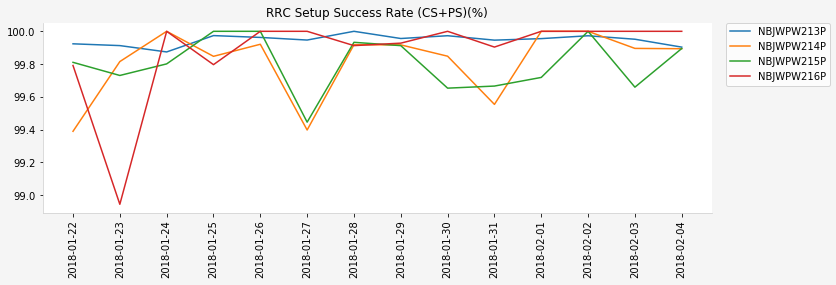

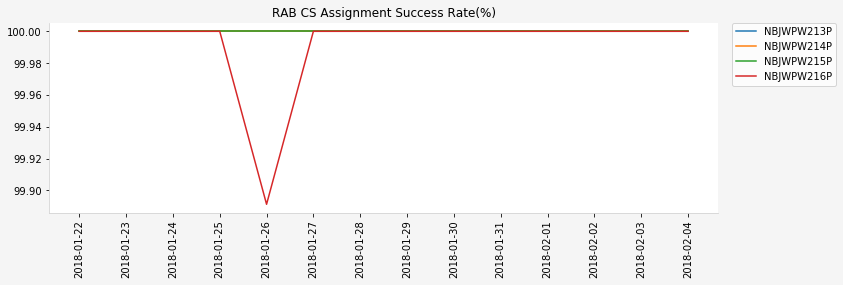

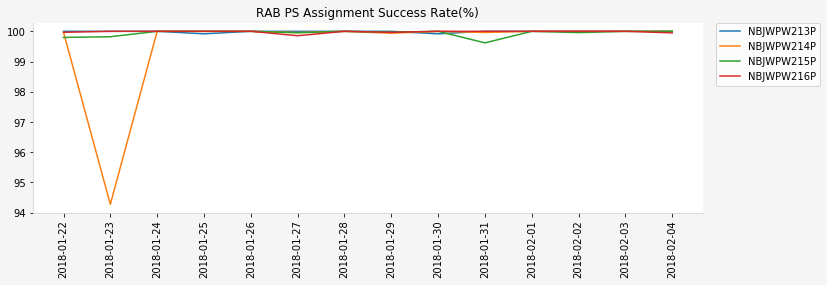

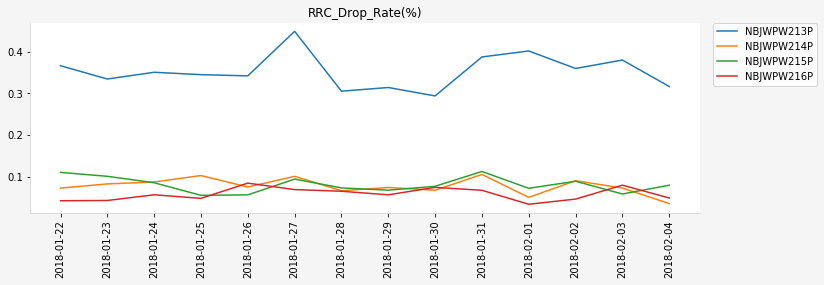

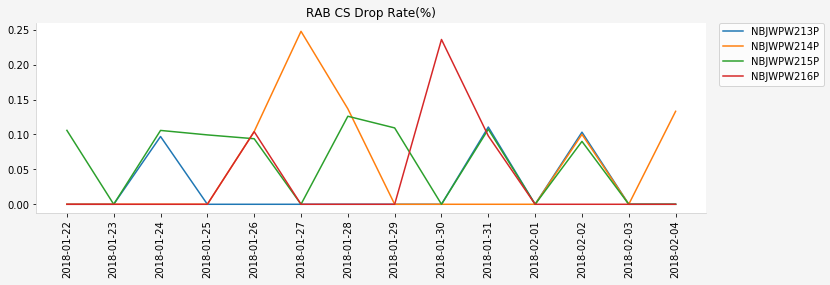

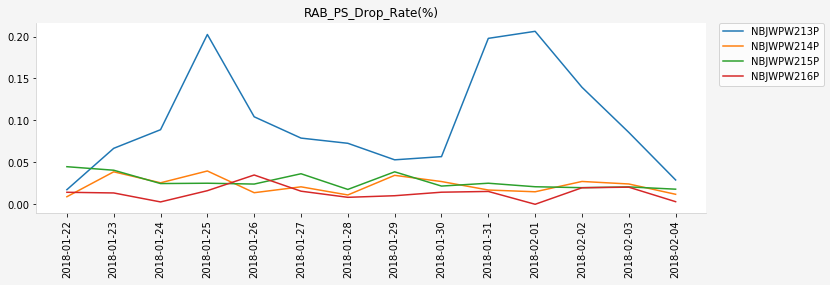

NBJWPW21SQ


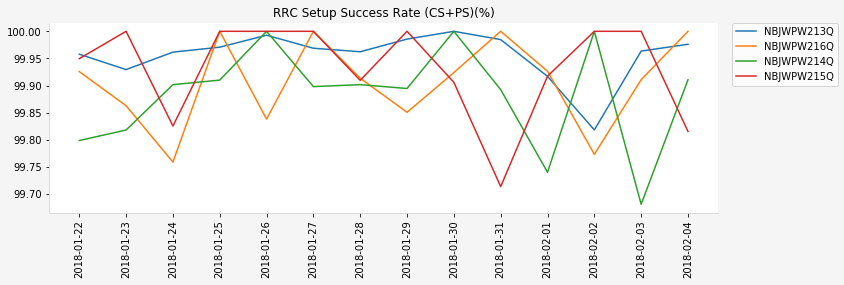

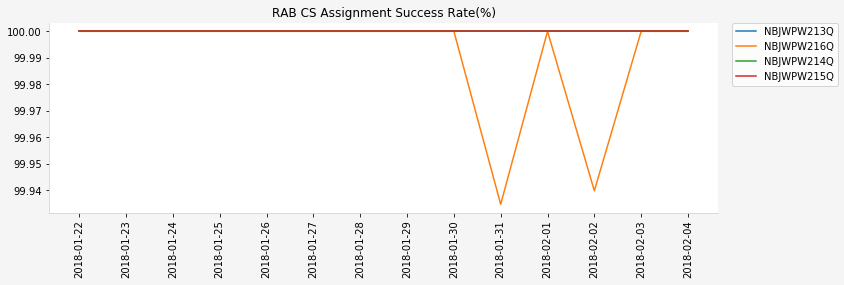

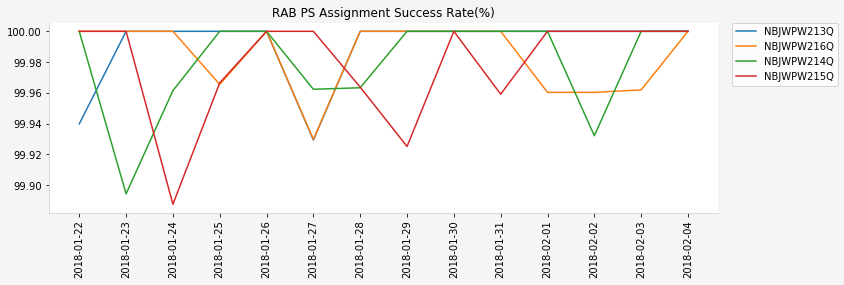

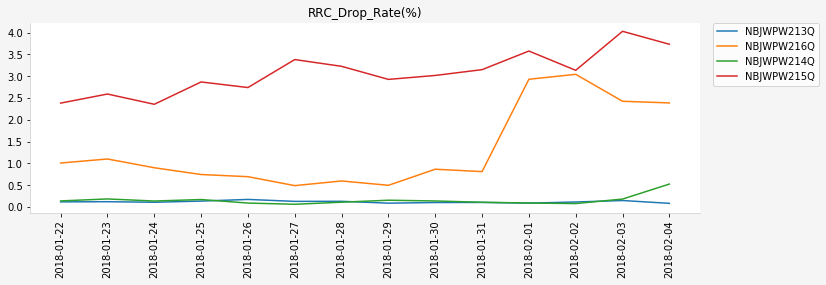

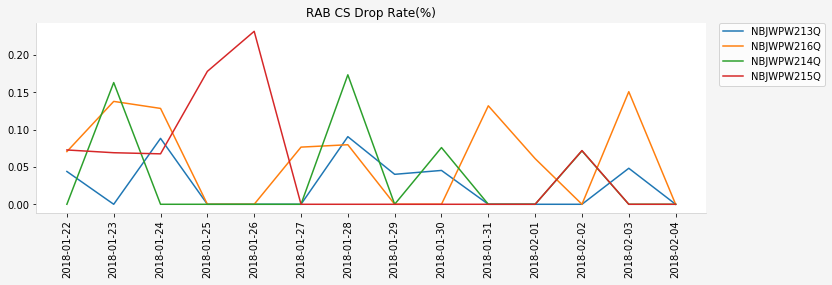

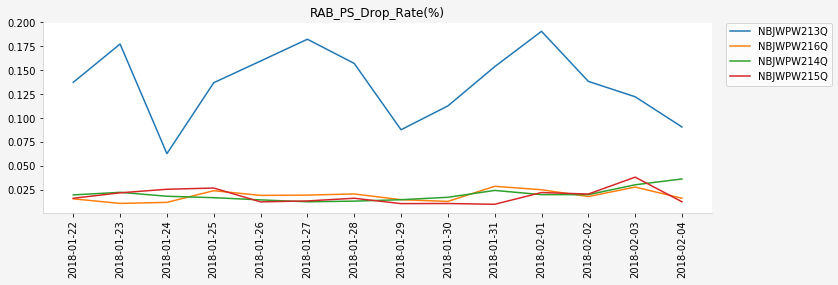

NBJWPW21SR


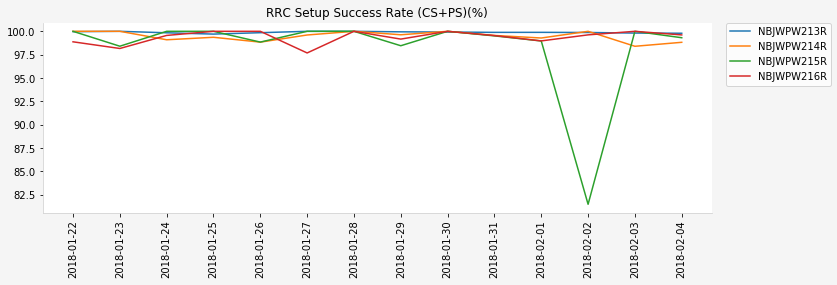

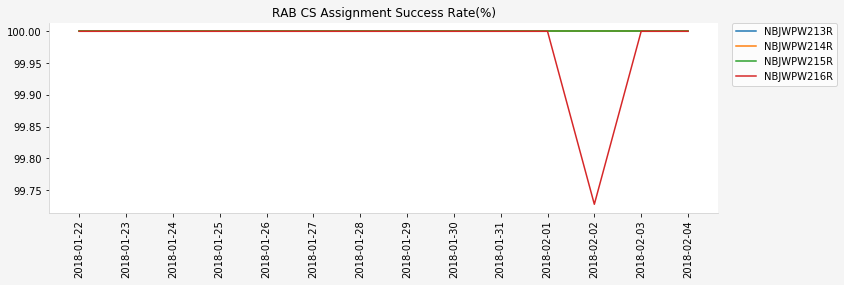

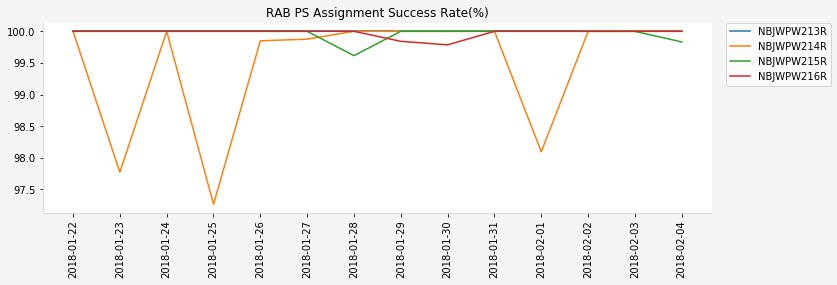

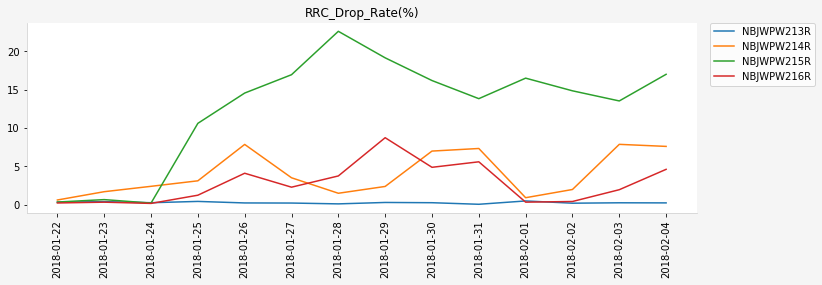

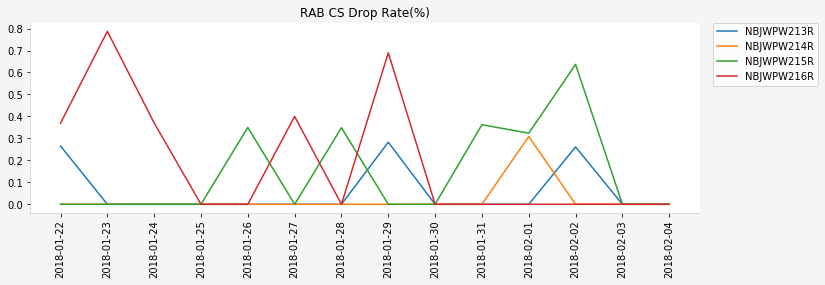

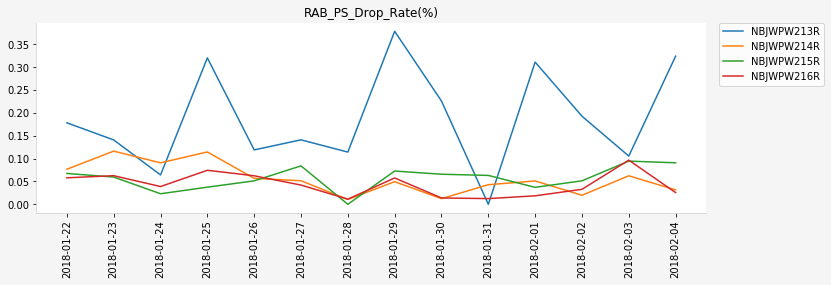

In [1]:
#按基站名称进行查询并按扇区显示
import pymysql.cursors
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

connection = pymysql.connect(host='localhost',
                             user='Test',
                             password='1234',
                             db='sts',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
if connection:
    print("connect to database successfully")
    
try:
    with connection.cursor() as cursor:
        # Read a single record
        SITENAME=input("Sitename=")
        SITENAME=SITENAME.strip().upper()
        StartDate=input("StartDate(\"YYYY-MM-DD\")=")
        StartDate=StartDate.strip()
        sql =("SELECT * FROM `daily_cell_sts_5.2` WHERE Time>= \'"+StartDate+"\'and CELLNAME LIKE'"+SITENAME+"%\' ORDER BY Time ASC")
        cursor.execute(sql)
        result2 = cursor.fetchall()
        if not result2:
            print("Query result is empty")
except:
    print("Error occured when querying")
finally:
    connection.close()

KPI=['RRC Setup Success Rate (CS+PS)(%)',
    'RAB CS Assignment Success Rate(%)',
    'RAB PS Assignment Success Rate(%)',
    'RRC_Drop_Rate(%)',
    'RAB CS Drop Rate(%)',
    'RAB_PS_Drop_Rate(%)']

if result2:
#结果转成DataFrame后增加列Sector，Frequency
    df=pd.DataFrame(result2)
    cn=df.CELLNAME.values.tolist()
    SECTOR=[]
    FREQUENCY=[]
#生成SECTOR和FREQUENCY
    for cell in cn:
        cell=cell.strip()
        sectorname=cell[0:8]+"S"+cell[-1]
        SECTOR.append(sectorname)
        flayer="F"+cell[-2]
        FREQUENCY.append(flayer)
    
    df=df.assign(SECTOR=pd.Series(SECTOR),FREQUENCY=pd.Series(FREQUENCY))

#按SECTOR生成KPI图
    sector_temp=df.SECTOR.values.tolist()
    sector_list=sorted(set(sector_temp),key=sector_temp.index)

    for sector in sector_list:
        print(sector)
        df_sector=df[df['SECTOR']==sector]
        cellname_temp=df_sector.CELLNAME.values.tolist()
        cellname_list=sorted(set(cellname_temp),key=cellname_temp.index)   
        for kpi in KPI:
            fig_number=+1
            plt.figure(fig_number)
            plt.figure(figsize=(12,3.5),facecolor='whitesmoke')
            ax=plt.subplot(111)
            for cell in cellname_list:
                df_cell=df_sector[df_sector['CELLNAME']==cell]
                ax.plot(df_cell['Time'],df_cell[kpi],'-',label=cell)
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  #设置日期间隔为1天
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax.set_xticks(df_cell['Time'])
            ax.set(title=kpi)
            ax.spines['top'].set_visible(False)  
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_color('lightgrey')  
            ax.spines['left'].set_color('lightgrey')  
            ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
            plt.xticks(rotation=90)
            
        plt.show()
    